In [2]:
!pip install pandas geopy scikit-learn matplotlib seaborn folium

In [3]:
# Import libraries
import pandas as pd
from geopy.distance import geodesic
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Load datasets
earthquake_data = pd.read_csv('/content/earthquake_data.csv')
building_data = pd.read_csv('/content/building_data.csv')
damage_reports = pd.read_csv('/content/damage_reports.csv')

# Define epicenter coordinates (using the first entry as example)
epicenter_lat = earthquake_data.iloc[0]['epicenter_lat']
epicenter_lon = earthquake_data.iloc[0]['epicenter_lon']

# Calculate distance from the epicenter
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

building_data['distance_to_epicenter'] = building_data.apply(
    lambda row: calculate_distance(row['location_lat'], row['location_lon'], epicenter_lat, epicenter_lon),
    axis=1
)


# Encode categorical features
label_encoder = LabelEncoder()
building_data['material_type'] = label_encoder.fit_transform(building_data['material_type'])

# Merge datasets
data = pd.merge(building_data, damage_reports, on='building_id')

# Prepare features and labels
X = data[['age', 'material_type', 'distance_to_epicenter']]
y = data['damage_level']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


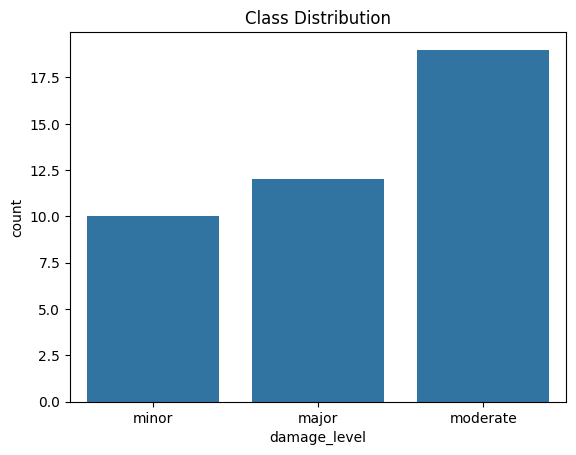

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='damage_level', data=data)
plt.title('Class Distribution')
plt.show()


In [5]:
# Initialize RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Define parameter grid for GridSearch
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=2, scoring='accuracy', n_jobs=-1)

# Fit GridSearch to the data
grid_search.fit(X_train, y_train)

# Best parameters and model
best_model = grid_search.best_estimator_
print(f'Best parameters: {grid_search.best_params_}')

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))


Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

       major       0.00      0.00      0.00         4
       minor       0.50      1.00      0.67         1
    moderate       0.40      0.50      0.44         4

    accuracy                           0.33         9
   macro avg       0.30      0.50      0.37         9
weighted avg       0.23      0.33      0.27         9



In [22]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)
X_Resampled, Y_resampled = smote_tomek.fit_resample(X, y)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_Resampled, Y_resampled, test_size=0.2, random_state=42)

In [20]:
# Initialize RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Define parameter grid for GridSearch
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=2, scoring='accuracy', n_jobs=-1)

# Fit GridSearch to the data
grid_search.fit(X_train, y_train)

# Best parameters and model
best_model = grid_search.best_estimator_
print(f'Best parameters: {grid_search.best_params_}')

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))


Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.7142857142857143
              precision    recall  f1-score   support

       major       0.50      0.50      0.50         2
       minor       0.67      1.00      0.80         2
    moderate       1.00      0.67      0.80         3

    accuracy                           0.71         7
   macro avg       0.72      0.72      0.70         7
weighted avg       0.76      0.71      0.71         7



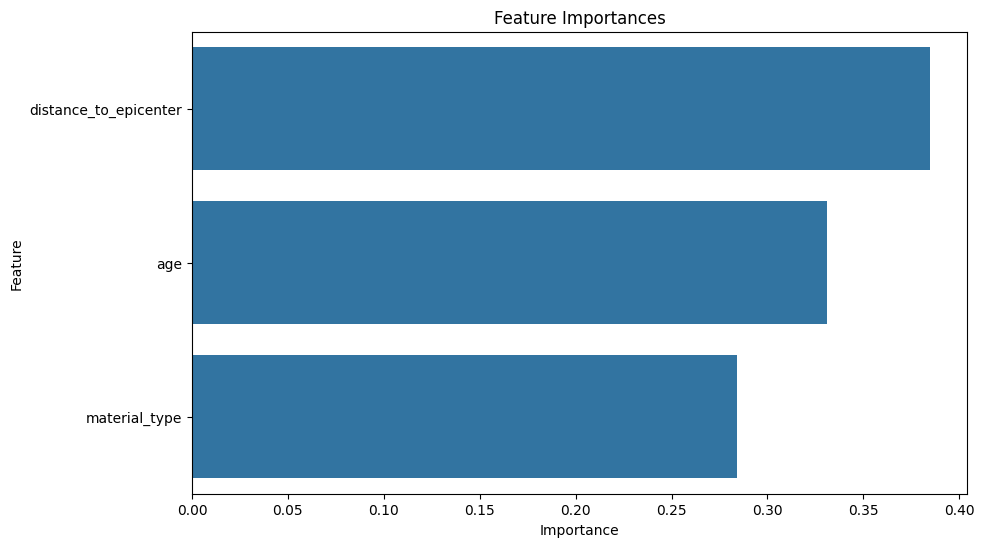

In [21]:
# Get feature importances
importances = best_model.feature_importances_
features = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()


In [39]:
# Example new data
new_data = pd.DataFrame({
    'age': [120, 85],
    'material_type': label_encoder.transform(['stone', 'masonry']),
    'distance_to_epicenter': [12.5, 3.0]
})

# Predict damage levels
damage_predictions = best_model.predict(new_data)
print(damage_predictions)


['moderate' 'minor']


In [40]:
# Initialize map centered on the epicenter
m = folium.Map(location=[epicenter_lat, epicenter_lon], zoom_start=12)

# Map damage levels to colors
damage_level_mapping = {'minor': 0, 'moderate': 1, 'major': 2}
damage_colors = ['green', 'orange', 'red']  # Assuming minor, moderate, major

for i, row in data.iterrows():
    damage_index = damage_level_mapping[row['damage_level']]
    folium.CircleMarker(
        location=[row['location_lat'], row['location_lon']],
        radius=5,
        color=damage_colors[damage_index],
        fill=True,
        fill_color=damage_colors[damage_index],
        fill_opacity=0.6,
        popup=f'Building ID: {row["building_id"]}, Damage Level: {row["damage_level"]}'
    ).add_to(m)

# Save map to an HTML file
m.save('damage_map.html')

In [44]:
print(data.columns)


Index(['building_id', 'age', 'material_type', 'location_lat', 'location_lon',
       'distance_to_epicenter', 'damage_level', 'simulated_magnitude',
       'simulated_depth', 'simulated_damage', 'risk_score'],
      dtype='object')


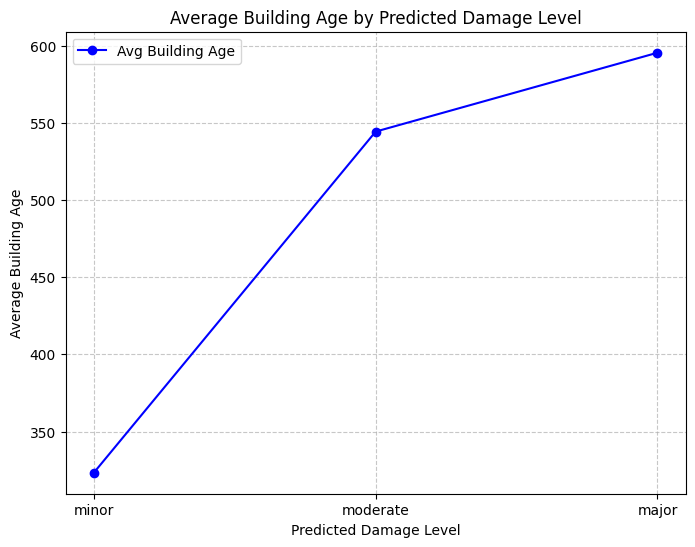

In [45]:
# Calculate the mean building age for each predicted damage level
age_means = data.groupby('simulated_damage')['age'].mean().reindex(['minor', 'moderate', 'major'])

# Plot a line graph
plt.figure(figsize=(8, 6))
plt.plot(age_means.index, age_means.values, marker='o', linestyle='-', color='blue', label='Avg Building Age')

# Add labels and title
plt.title('Average Building Age by Predicted Damage Level')
plt.xlabel('Predicted Damage Level')
plt.ylabel('Average Building Age')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


<ipython-input-46-d4a1c6e85fb5>:7: FutureWarning: The provided callable <function mean at 0x79cebc3f95a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  risk_pivot = data.pivot_table(values='risk_score', index='location_lat', columns='location_lon', aggfunc=np.mean)


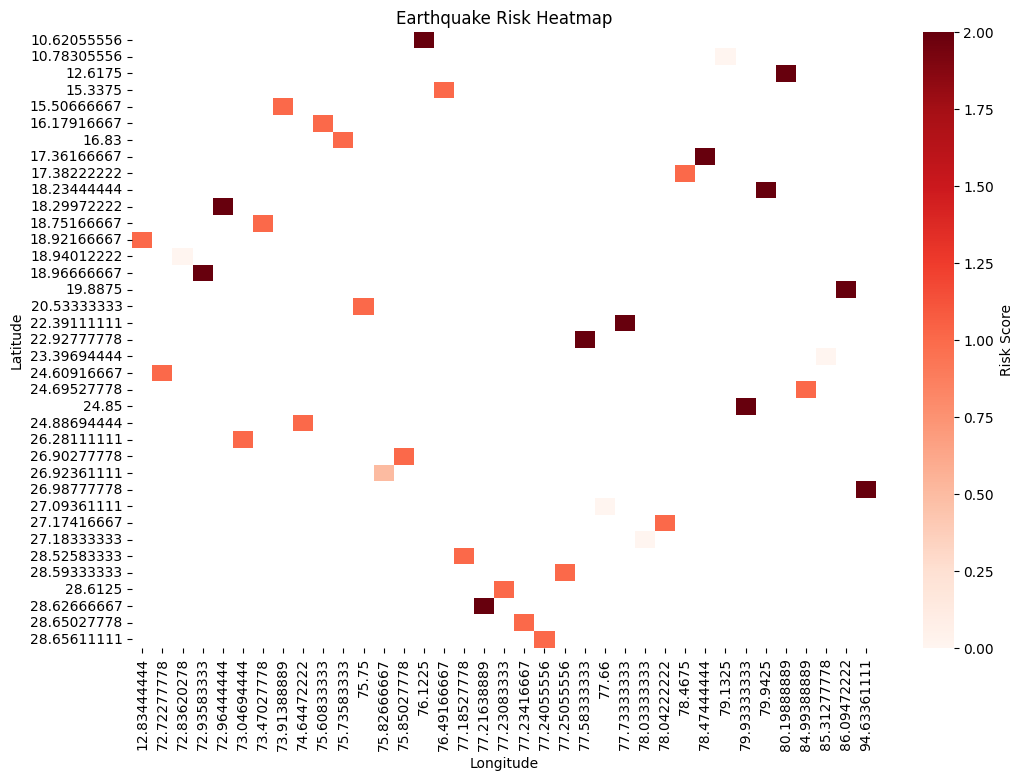

In [46]:
import numpy as np

# Create risk scores: Major damage = 2, Moderate = 1, Minor = 0
data['risk_score'] = data['simulated_damage'].apply(lambda x: 2 if x == 'major' else (1 if x == 'moderate' else 0))

# Create a pivot table for heatmap
risk_pivot = data.pivot_table(values='risk_score', index='location_lat', columns='location_lon', aggfunc=np.mean)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(risk_pivot, cmap='Reds', cbar_kws={'label': 'Risk Score'})
plt.title('Earthquake Risk Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [47]:
# Simulate an earthquake with new magnitude and depth
new_magnitude = 5.0
new_depth = 20.0

# Add simulated data to the dataset
data['simulated_magnitude'] = new_magnitude
data['simulated_depth'] = new_depth

# Use the model to predict damage levels for the simulated scenario
data['simulated_damage'] = best_model.predict(X)

# Compare original and simulated damage levels
print(data[['building_id', 'simulated_damage']])


    building_id simulated_damage
0             1            minor
1             2            major
2             3         moderate
3             4            minor
4             5         moderate
5             6         moderate
6             7            major
7             8            major
8             9            major
9            10         moderate
10           11         moderate
11           12            minor
12           13            major
13           14         moderate
14           15         moderate
15           16         moderate
16           17            major
17           18         moderate
18           19            minor
19           20         moderate
20           21            minor
21           22            major
22           23            major
23           24         moderate
24           25            minor
25           26            major
26           27         moderate
27           28         moderate
28           29         moderate
29        

In [28]:
# Highlight high-risk buildings (major damage)
high_risk_buildings = data[data['simulated_damage'] == 'major']
print("High-Risk Buildings (Major Damage):")
print(high_risk_buildings[['building_id', 'location_lat', 'location_lon']])


High-Risk Buildings (Major Damage):
    building_id  location_lat  location_lon
1             2     10.620556     76.122500
6             7     22.927778     77.583333
7             8     22.391111     77.733333
8             9     24.850000     79.933333
12           13     17.361667     78.474444
16           17     18.234444     79.942500
21           22     12.617500     80.198889
22           23     19.887500     86.094722
25           26     18.966667     72.935833
33           34     26.987778     94.633611
34           35     28.626667     77.216389
35           36     28.626667     77.216389
36           37     26.987778     94.633611
37           38     26.987778     94.633611
39           40     18.299722     72.964444
